In [8]:
%%bash
ls trainPart1

train


In [9]:
import numpy as np
import pandas as pd
import cv2
import os

float32
(900, 1200, 3)


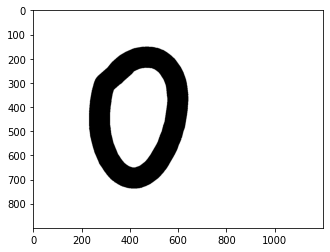

In [10]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('trainPart1/train/Sample001/img001-001.png')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [11]:
data.shape

(900, 1200, 3)

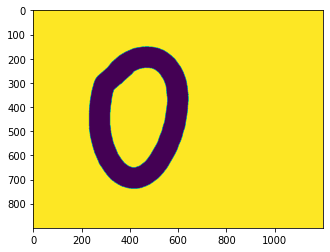

In [12]:
pyplot.imshow(data[:,:,0])

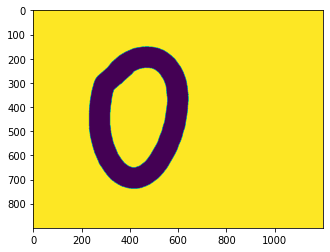

In [13]:
pyplot.imshow(data[:,:,1])

In [14]:
data.shape[0]

900

In [15]:
new_data=data[:,:,0]+data[:,:,1]+data[:,:,2]
new_data=new_data/3


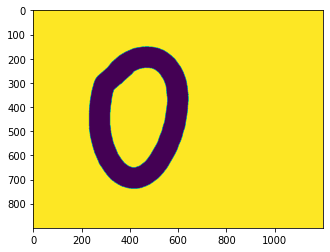

In [16]:
pyplot.imshow(new_data)

In [17]:
count=0
for i in new_data:
    for j in i:
        count+=j

In [18]:
dim=new_data.shape[0]*new_data.shape[1]

In [19]:
count/dim

0.8940333333333333

In [20]:
new_data[700,400]

0.0

In [21]:
def get_fine_bounds(data,
                    coordinate_1,
                    coordinate_2,
                    point_is_visited = [[0 for i in range(data.shape[1])] for j in range(data.shape[0])],
                    bound={'left':2000,'right':0,'up':1000,'down':0},
                    points_to_travel=[]):
#Given a point, look for other neighbouring points.
    points_to_travel.append([coordinate_1,coordinate_2])

    while(points_to_travel):
        coordinate_1, coordinate_2= points_to_travel.pop()
        #print("vistinf " + str(coordinate_1) +","+ str(coordinate_2))
        point_is_visited[coordinate_1][coordinate_2]=1
        neighbours=[[coordinate_1+1,coordinate_2],
                    [coordinate_1-1,coordinate_2],
                    [coordinate_1,coordinate_2+1],
                    [coordinate_1,coordinate_2-1]]
        for point in neighbours:
            coordinate_1, coordinate_2= point
            if data[coordinate_1,coordinate_2]==0.0 and point_is_visited[coordinate_1][coordinate_2]==0:
                bound['left']=min(coordinate_2,bound['left'])
                bound['right']=max(coordinate_2,bound['right'])
                bound['up']=min(coordinate_1,bound['up'])
                bound['down']=max(coordinate_1,bound['down'])
                points_to_travel.append([coordinate_1,coordinate_2])
    return bound

In [22]:
def get_bounds(data):
    padding=int((data.shape[1]-data.shape[0])/2)

    #Search starting from point (padding,0) diagonally upwards.
    for i in range(padding+10,data.shape[0]-10):
        if data[i,padding+i]==0.0:
            return get_fine_bounds(data,i,padding+i)
  
  #Search starting from point (padding,data.shape[0]) diagonally downwards.
    for i in range(padding+10,data.shape[0]-10):
        if data[data.shape[0]-i,padding+i]==0.0:
            return get_fine_bounds(data,data.shape[0]-i,padding+i)
  
  #Search along the line that divides the picture into two halves horizontally.
    for i in range(padding+10,data.shape[0]-10):
        if data[int(data.shape[0]/2),i]==0.0:
            return get_fine_bounds(data,int(data.shape[0]/2),i)
  
  #Search along the line that divides the picture into two halves vertically.
    for i in range(padding+10,data.shape[0]-10):
        if data[i,int(data.shape[1]/2)]==0.0:
            return get_fine_bounds(data,i,int(data.shape[1]/2))

  #finally, fall back to the naive method.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j]==0.0:
                return get_fine_bounds(data,i,j)

In [23]:
result=get_bounds(new_data)

In [24]:
print(result)

{'left': 232, 'right': 642, 'up': 151, 'down': 736}


In [25]:
width_req, height_req=[28,28]
dataframe={'label':[]}
for i in range(1,width_req*height_req+1):
    dataframe['pixel'+str(i)]=[]
df = pd.DataFrame(dataframe)
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784


In [26]:
# df.loc[len(df.index)]=['0' for i in range(785)]
# df.index

In [27]:
def pad_data(data,result,hori_shift,verti_shift):
    
    compare = result['left'] - hori_shift
    if compare < 0:
        for i in range(-compare):
            for j in range(result['up'],result['down']+1):
                data[j].insert(0,1)
    
    compare = result['right'] + hori_shift - data.shape[1]
    if compare > 0:
        for i in range(compare):
            for j in range(result['up'],result['down']+1):
                data[j].insert(data.shape[1]-1,1)
    
    compare = result['up'] - verti_shift
    if compare < 0:
        for i in range(-compare):
            for j in range(result['left'],result['right']+1):
                data[j].insert(data.shape[0]-1,1)
    
    compare = result['down'] + verti_shift - data.shape[0]
    if compare > 0:
        for i in range(compare):
            for j in range(result['left'],result['right']+1):
                data[j].insert(data.shape[0]-1,1)

In [42]:
def center_and_downsample_image(data):
    result=get_bounds(data)
    width_req, height_req = result['right'] - result['left'], result['down'] - result['up']
    hori_shift=0.1*width_req 
    verti_shift=0.1*height_req
    pad_data(data,result,hori_shift,verti_shift)

    res = cv2.resize(data[int(result['left']-hori_shift):int(result['right']+hori_shift),
                    int(result['up']-verti_shift):int(result['down']+verti_shift)],
                    dsize=(28,28),
                    interpolation=cv2.INTER_LINEAR) #a bilinear interpolation
    temparray=np.asarray(res)
    temparray=1-temparray
    temparray=temparray*255
    temparray=temparray.astype(int)
    temparray=np.resize(temparray,(1,28*28))
    return temparray

In [43]:
artoplot=[]
for img in os.listdir('trainPart1/train/Sample001'):
    data = image.imread('trainPart1/train/Sample001'+'/'+img)
    data=data[:,:,0]+data[:,:,1]+data[:,:,2]
    data=data/3
    finalarr=center_and_downsample_image(data)
    artoplot.append(finalarr)

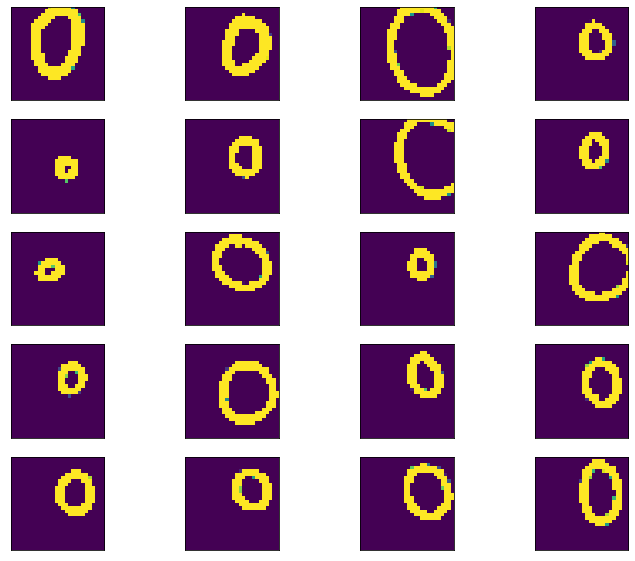

In [44]:
pyplot.figure(figsize=(12, 10))
for i in range(20):
    pyplot.subplot(5, 4, i+1)
    pyplot.grid(False)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.imshow(artoplot[i].reshape(28,28))

In [21]:
dirtochar={
 'Sample001': '0',
 'Sample002': '1',
 'Sample003': '2',
 'Sample004': '3',
 'Sample005': '4',
 'Sample006': '5',
 'Sample007': '6',
 'Sample008': '7',
 'Sample009': '8',
 'Sample010': '9',
 'Sample011': 'A',
 'Sample012': 'B',
 'Sample013': 'C',
 'Sample014': 'D',
 'Sample015': 'E',
 'Sample016': 'F',
 'Sample017': 'G',
 'Sample018': 'H',
 'Sample019': 'I',
 'Sample020': 'J',
 'Sample021': 'K',
 'Sample022': 'L',
 'Sample023': 'M',
 'Sample024': 'N',
 'Sample025': 'O',
 'Sample026': 'P',
 'Sample027': 'Q',
 'Sample028': 'R',
 'Sample029': 'S',
 'Sample030': 'T',
 'Sample031': 'U',
 'Sample032': 'V',
 'Sample033': 'W',
 'Sample034': 'X',
 'Sample035': 'Y',
 'Sample036': 'Z',
 'Sample037': 'a',
 'Sample038': 'b',
 'Sample039': 'c',
 'Sample040': 'd',
 'Sample041': 'e',
 'Sample042': 'f',
 'Sample043': 'g',
 'Sample044': 'h',
 'Sample045': 'i',
 'Sample046': 'j',
 'Sample047': 'k',
 'Sample048': 'l',
 'Sample049': 'm',
 'Sample050': 'n',
 'Sample051': 'o',
 'Sample052': 'p',
 'Sample053': 'q',
 'Sample054': 'r',
 'Sample055': 's',
 'Sample056': 't',
 'Sample057': 'u',
 'Sample058': 'v',
 'Sample059': 'w',
 'Sample060': 'x',
 'Sample061': 'y',
 'Sample062': 'z'
 }

In [22]:
for sample in os.listdir('trainPart1/train'):
    for img in os.listdir('trainPart1/train/'+sample):
        data = image.imread('trainPart1/train/'+sample+'/'+img)
        data=data[:,:,0]+data[:,:,1]+data[:,:,2]
        data=data/3
        finalarr=center_and_downsample_image(data)
        finalarr=finalarr.tolist()
        finalarr=finalarr[0]
        finalarr.insert(0,dirtochar[sample])
        df.loc[len(df.index)]=finalarr
    print('Completed with '+sample+'/Sample062')

Completed with Sample001/Sample062
Completed with Sample002/Sample062
Completed with Sample003/Sample062
Completed with Sample004/Sample062
Completed with Sample005/Sample062
Completed with Sample006/Sample062
Completed with Sample007/Sample062
Completed with Sample008/Sample062
Completed with Sample009/Sample062
Completed with Sample010/Sample062
Completed with Sample011/Sample062
Completed with Sample012/Sample062
Completed with Sample013/Sample062
Completed with Sample014/Sample062
Completed with Sample015/Sample062
Completed with Sample016/Sample062
Completed with Sample017/Sample062
Completed with Sample018/Sample062
Completed with Sample019/Sample062
Completed with Sample020/Sample062
Completed with Sample021/Sample062
Completed with Sample022/Sample062
Completed with Sample023/Sample062
Completed with Sample024/Sample062
Completed with Sample025/Sample062
Completed with Sample026/Sample062
Completed with Sample027/Sample062
Completed with Sample028/Sample062
Completed with Sampl

In [23]:
a=[10,20]
b=np.ndarray(a)
a=np.insert(a,1,2)
a

array([10,  2, 20])

In [24]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2476,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2477,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2478,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df.to_csv('preprocessed.csv', index = False)